# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpltern
import matplotlib as mpl
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist

from sklearn.decomposition import PCA
import cvxpy as cvx
import numpy as np

In [2]:
colors = ['g', 'b', 'y', 'k', 'r'] * 20

# Utils

In [3]:
def s_energy(simplex_points, d=3):
    diff = simplex_points[:, None] - simplex_points[None, :]
    distance = np.sqrt((diff**2).sum(axis=2))
    np.fill_diagonal(distance, np.inf)
    epsilon = 1e-4  # epsilon is the smallest distance possible to avoid overflow during gradient calculation
    distance[distance < epsilon] = epsilon
    # select only upper triangular matrix to have each mutual distance once
    mutual_dist = distance[np.triu_indices(len(simplex_points), 1)]
    mutual_dist[np.argwhere(mutual_dist == 0).flatten()] = epsilon
    energies = (1 / mutual_dist ** 2)  # calculate energy by summing up the squared distances
    energy = energies[~np.isnan(energies)].sum()
    log_energy = -np.log(len(mutual_dist)) + np.log(energy)
    return log_energy

In [4]:
def projection_simplex(V, z=1):
    """Projection of x onto the simplex, scaled by z.

    P(x; z) = argmin_{y >= 0, sum(y) = z} ||y - x||^2
    """
    n_features = V.shape[1]
    U = np.sort(V, axis=1)[:, ::-1]
    z = np.ones(len(V)) * z
    cssv = np.cumsum(U, axis=1) - z[:, np.newaxis]
    ind = np.arange(n_features) + 1
    cond = U - cssv / ind > 0
    rho = np.count_nonzero(cond, axis=1)
    theta = cssv[np.arange(len(V)), rho - 1] / rho
    return np.maximum(V - theta[:, np.newaxis], 0)

In [5]:
def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)
    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)
        if abs(value) <= tau:
            break
        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint
    return np.maximum(v - midpoint, 0)

# Analyze run

best z: 0.22930630630630627
lowest log energy: 4.052940296728375


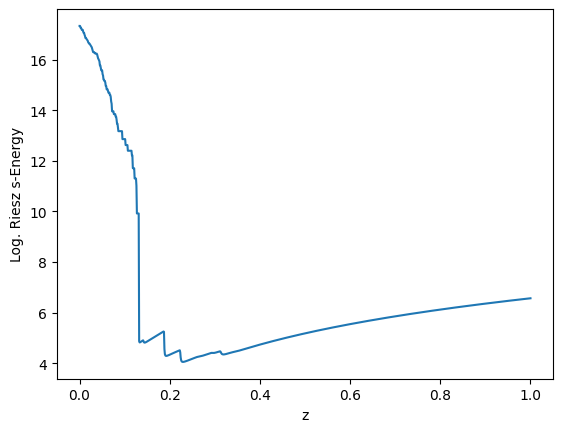

In [6]:
root_path = f'../raw_client_gradients.npy'
grads = np.load(
    root_path,
    allow_pickle=True
)

grad_dict = grads.item()
grad_array = np.array(list(grad_dict.values()))

dim_red_client_statistics = PCA(
    n_components=3
).fit_transform(grad_array)

statistics_over_z = []
energies_over_z = []
best_z = None
last_log_energy = np.inf
z_grid = np.linspace(1e-4,1,1000)
for i, z in enumerate(z_grid):
    final_client_statistics = projection_simplex(dim_red_client_statistics, z=z)
    final_client_statistics /= final_client_statistics.sum(1).reshape(-1,1)
    statistics_over_z.append(final_client_statistics)
    log_energy = s_energy(final_client_statistics, d=2)
    if log_energy not in [-np.inf, np.inf]:
        energies_over_z.append(log_energy)
        if log_energy < last_log_energy:
            best_z = i
            last_log_energy = log_energy

plt.plot(z_grid, energies_over_z)
plt.ylabel('Log. Riesz s-Energy')
plt.xlabel('z')
print(f'best z: {z_grid[best_z]}')
print(f'lowest log energy: {energies_over_z[best_z]}')

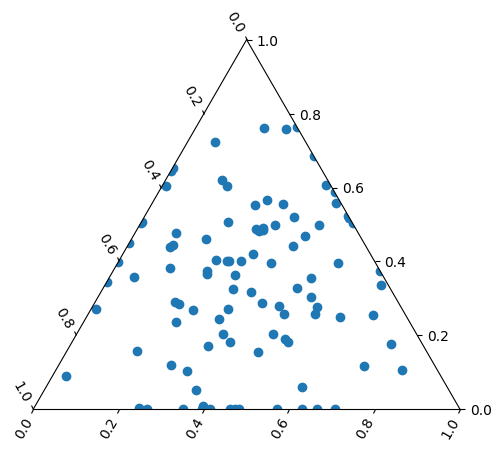

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection="ternary")
ax1.scatter(
    statistics_over_z[best_z][:,0],
    statistics_over_z[best_z][:,1],
    statistics_over_z[best_z][:,2]
    )

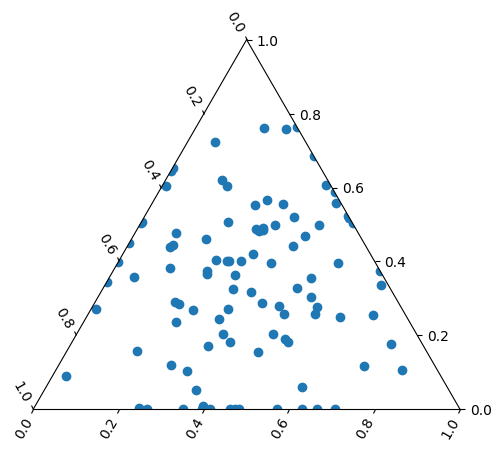

In [8]:
root_path = f'../final_client_gradients.npy'
processed_grads = np.load(
    root_path,
    allow_pickle=True
)
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection="ternary")
ax1.scatter(
    processed_grads[:,0],
    processed_grads[:,1],
    processed_grads[:,2]
    )